# Flows with multiple effects 

This module covers how we can analyze compressible flows with multiple effects accelerating or decelerating the flow: area change, friction, and/or heat transfer (plus shocks!).

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# Pint gives us some helpful unit conversion
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity # We will use this to construct quantities (value + unit)

In [16]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 200
plt.rcParams['savefig.dpi'] = 200

## Flows with friction and area change

This differential equation describes how Mach number changes in a compressible flow due to the effects of both area change (via $dA/dx$) and friction:

$$
\frac{1}{2} \gamma M^2 \frac{f}{D} = \frac{1}{A} \frac{dA}{dx} + \frac{2 (1-M^2)}{M \left[ 2 + (\gamma-1) M^2 \right]} \frac{dM}{dx} 
$$ (eq_friction_area)

## Isentropic flow in converging nozzle

Consider air flowing isentropically (and so $f = 0$) in a conically shaped converging nozzle, 
with length 10 cm, initial area of 50 cm$^2$,
outlet area of 40 cm$^2$. The inflow temperature is 300 K and velocity is 100 m/s.

Find the outlet Mach number and compare against the exact solution.

For a conical nozzle, we can express the area using

$$
A(x) = \frac{\pi}{4} D(x)^2 = \frac{\pi}{4} \left( D_i + \frac{D_o - D_i}{L} \right)^2
$$

Then, the area term is

$$
\frac{1}{A(x)} \frac{dA}{dx} = \frac{2}{D(x)} \frac{dD}{dx} = \frac{2 \frac{D_o - D_i}{L}}{D(x)} \;,
$$

where the diameter is expressed as $ D(x) = D_i + (D_o - D_i) \frac{x}{L} $.

Substituting this into Equation {eq}`eq_friction_area`, since $f = 0$, we get 

$$
\frac{dM}{dx} = F(x,M) = - \left[ \frac{(D_o - D_i) / L}{D(x)} \right] \frac{2 + (\gamma-1)M^2}{1 - M^2} M \;,
$$

which we can integrate over $x = [0, L]$ with the initial condition $ M(x=0) = M_i = V_i / a_i $.

In [121]:
gamma = 1.4
R = Q_(287, 'J/(kg*K)')
length = Q_(10, 'cm').to('m')
area_in = Q_(50, 'cm^2').to('m^2')
area_out = Q_(40, 'cm^2').to('m^2')

temperature_in = Q_(300, 'K')
velocity_in = Q_(100, 'm/s')

In [122]:
diameter_in = np.sqrt(area_in * 4 / np.pi)
diameter_out = np.sqrt(area_out * 4 / np.pi)

speed_sound_in = np.sqrt(gamma * R * temperature_in)
mach_in = (velocity_in / speed_sound_in).to_base_units()
print(f'M_in = {mach_in.magnitude: .4f}')

M_in =  0.2880


In [123]:
def dMdx_isentropic(x, M, gamma, D_in, D_out, length):
    '''Equation for dM/dx in isentropic flow'''
    # conical nozzle
    diameter = D_in + (D_out - D_in) * x / length
    
    return (-M * ((D_out - D_in) / length / diameter) *
        ((2 + (gamma-1) * M**2) / (1 - M**2))
        )

In [124]:
# integrate from x = 0 to L, using maximum step size of 1 cm
sol = solve_ivp(
    dMdx_isentropic, [0, length.to('m').magnitude], [mach_in.magnitude], 
    max_step=0.01,
    args=(gamma, diameter_in.to('m').magnitude, 
          diameter_out.to('m').magnitude, length.to('m').magnitude
         )
    )

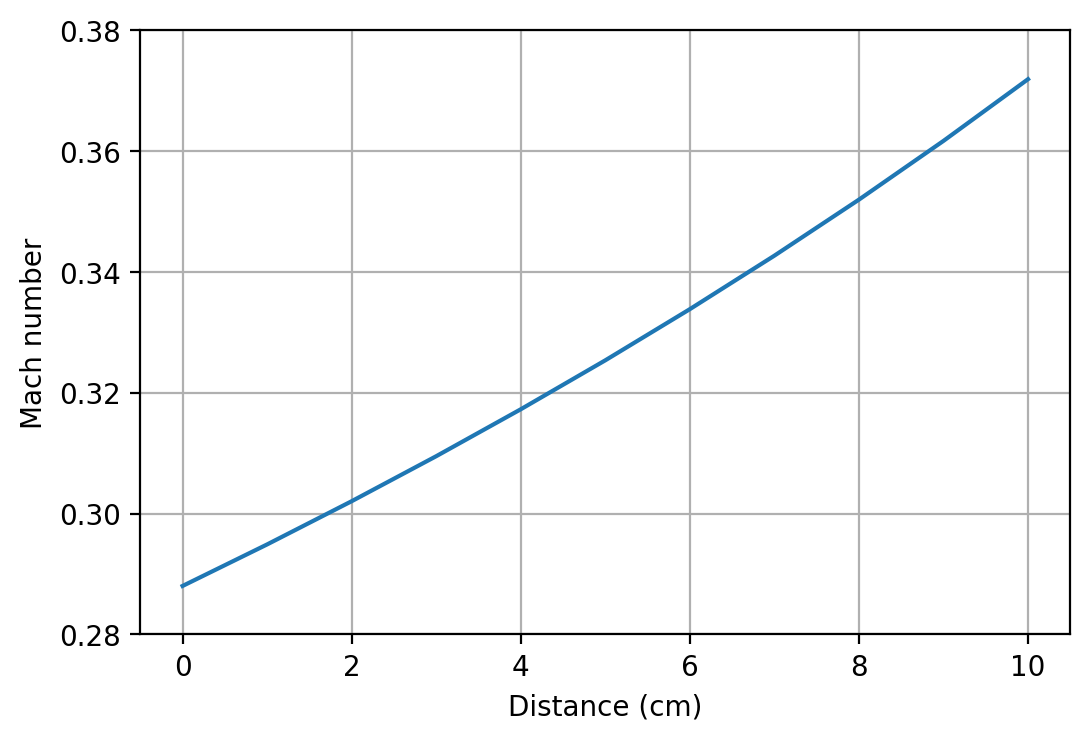

In [47]:
plt.plot(sol.t * 100, sol.y[0,:])

plt.ylim([0.28, 0.38])
plt.grid(True)
plt.ylabel('Mach number')
plt.xlabel('Distance (cm)')
plt.show()

In [125]:
# compare against exact solution

mach_out = sol.y[0,-1]
print(f'M_out (numerical): {mach_out: .4f}')

def isentropic_area_ratio(mach2, mach1, area_ratio, gamma=1.4):
    '''Function for isentropic area ratio equation, solving for M2'''
    return (
        area_ratio - (mach1 / mach2) * (
            (1 + 0.5*(gamma-1)*mach2**2) / (1 + 0.5*(gamma-1)*mach1**2)
            )**((gamma+1) / (2*(gamma-1)))
        )

root = root_scalar(
    isentropic_area_ratio, x0=0.1, x1=0.5,
    args=(mach_in.magnitude, (area_out/area_in).to_base_units().magnitude, gamma))
mach_out_exact = root.root
print(f'M_out (exact) = {mach_out_exact:.4f}')

print(f'Error: {100*np.abs(mach_out_exact-mach_out)/mach_out_exact: .3e} %')

M_out (numerical):  0.3719
M_out (exact) = 0.3719
Error:  1.206e-10 %


## Subsonic flow with friction in constant area duct

Next, consider air flow in a constant area duct with friction. (This is Fanno flow.)
The initial Mach number is $M_i = 0.6$, the duct length is 45 cm, the diameter is 3 cm, and the friction factor is 0.02.

Find the outlet Mach number, and compare against the exact solution.

Since the area is constant, $ \frac{dA}{dx} = 0$, and Equation {eq}`eq_friction_area` simplifies to

$$
\frac{dM}{dx} = F(x,M) = \frac{\gamma M^3 \left[ 2 + (\gamma-1) M^2 \right]}{4 (1-M^2)} \frac{f}{D} \;,
$$

which we can integrate over $x = [0, L]$ with initial condition $ M(x=0) = M_i $.

In [4]:
gamma = 1.4
R = Q_(287, 'J/(kg*K)')
length = Q_(45, 'cm')
diameter = Q_(3, 'cm')
friction_factor = 0.02
mach_in = 0.60

In [5]:
def dMdx_fanno(x, M, gamma, f, D):
    '''Equation for dM/dx in Fanno flow'''    
    return (gamma * M**3 * (2 + (gamma-1)*M**2) * (f / D) /
        (4 * (1 - M**2))
        )

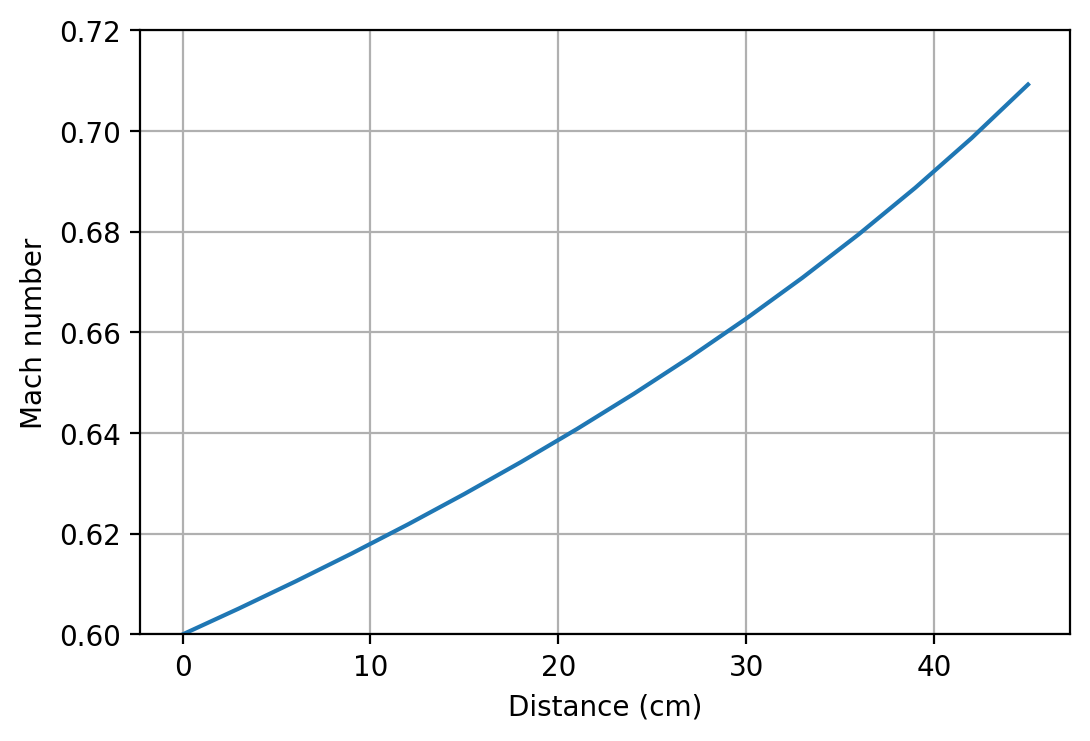

In [21]:
# integrate from x = 0 to L, using maximum step size of 3 cm
sol = solve_ivp(
    dMdx_fanno, [0, length.to('m').magnitude], [mach_in], 
    max_step=0.03,
    args=(gamma, friction_factor, diameter.to('m').magnitude)
    )

mach_out = sol.y[0,-1]

plt.plot(sol.t * 100, sol.y[0,:])

plt.ylim([0.60, 0.72])
plt.grid(True)
plt.ylabel('Mach number')
plt.xlabel('Distance (cm)')
plt.show()

In [22]:
# compare with exact solution
print(f'M_out (numerical): {mach_out: .4f}')

def fanno_distance(mach_2, mach_1, delta_x, friction, diameter, gamma=1.4):
    '''Function for Fanno flow, solving for M2'''
    return (
        (friction * delta_x / diameter) -  (((gamma+1)/(2*gamma)) *
            np.log((1 + 0.5*(gamma-1)*mach_2**2) / (1 + 0.5*(gamma-1)*mach_1**2)) -
            (1/gamma)*(1 / mach_2**2 - 1 / mach_1**2) -
            (gamma+1) * np.log(mach_2**2 / mach_1**2) / (2*gamma)
            )
        )

root = root_scalar(
    fanno_distance, x0=0.7, x1=0.8,
    args=(mach_in, length.to('m').magnitude, friction_factor, 
          diameter.to('m').magnitude, gamma)
          )
mach_out_exact = root.root
print(f'M_out (exact) = {mach_out_exact:.4f}')

print(f'Error: {100*np.abs(mach_out_exact-mach_out)/mach_out_exact: .4e} %')

M_out (numerical):  0.7093
M_out (exact) = 0.7093
Error:  3.1377e-09 %


## Flows with area change and friction

When the flow encounters both area change and friction, we need to solve the full version of Equation {eq}`eq_friction_area`, rearranged for convenience:

$$
\frac{dM}{dx} = F(x,M) = \left\{ \frac{M \left[ 2 + (\gamma - 1)M^2 \right]}{2} \right\} \left\{ \frac{ -\frac{1}{A} \frac{dA}{dx} + \frac{1}{2} \gamma M^2 \frac{f}{D}}{1 - M^2} \right\}
$$ (eq_area_friction_func)

We can integrate this in theory, but if we want to analyze converging-diverging nozzles that are choked, as $ M \rightarrow 1 $ at some location, then $ \frac{dM}{dx} \rightarrow \infty $. So, we need some special treatment to handle this singularity.

The method of Beans {cite}`beans1970` uses l'Hôpital's rule to get a finite value for $ \frac{dM}{dx}$ as the Mach number approches one.

In [100]:
gamma = 1.4
f = 0.4
angle = np.arcsin(gamma * f * 2 / (4*np.pi))
if angle < np.pi:
    angle = angle + np.pi
x_L_sp = (1/np.pi) * angle
print(f'x/L sonic = {x_L_sp: .4f}')

x/L sonic =  1.0284


In [101]:
# for solving quadratic equation at M = 1
Dsp = 2*(1 + 0.5*np.cos(np.pi*x_L_sp)) # * Dt
dD_dx_sp = -np.pi * np.sin(np.pi * x_L_sp) # *Dt/L
d2D_dx2_sp = -np.pi**2 * np.cos(np.pi * x_L_sp) # * Dt/L^2

a = 4 / (gamma + 1)
b = 2 * gamma * f / Dsp
c = -2*d2D_dx2_sp/Dsp + 2*(dD_dx_sp/Dsp)**2 - 2*gamma*f*dD_dx_sp/(2*Dsp**2)

# dM/d(x/L) at sonic point
roots = np.roots([a, b, c])
# take the positive root for accelerating flow
dM_dxL_sp = np.max(roots)

In [102]:
dM_dxL_sp

3.10940419851572

In [103]:
def area_function(x_L):
    '''Function for (1/A)*(dA/dx) using x/L'''
    return (-np.pi * np.sin(np.pi * x_L) / 
            (1 + 0.5 * np.cos(np.pi * x_L))
        )

def diameter_function(x_L):
    '''Function for nondimensional D'''
    return (1 + 0.5*np.cos(np.pi * x_L))

def dMdx_friction_area(x_L, M, gamma, area_func, f, diameter_func, dM_dxL_sp):
    '''dM/dx for flows with friction and area change.
    
    area_func is a function for (1/A)*(dA/dx)
    '''
    # when in neighborhood of M = 1, use special version of dM/dx
    if np.abs(M - 1) < 0.01:
        return dM_dxL_sp
    else:
        return (
            0.5*M*(2 + (gamma-1)*M**2) * (
                -area_func(x_L) + 0.5*gamma*M**2 * f/diameter_func(x_L)
                ) / (1 - M**2)
            )

In [104]:
# integrate x/L from sonic point to 0
x_vals = np.hstack(([x_L_sp], np.arange(1, 0, -0.05), [0]))

sol_sub = solve_ivp(
    dMdx_friction_area, [x_L_sp, 0], [1.0], 
    t_eval=x_vals,
    args=(gamma, area_function, f, diameter_function, dM_dxL_sp)
    )

# integrate x/L from sonic point to 2
x_vals = np.hstack(([x_L_sp], np.arange(1.05, 2.05, 0.05)))

sol_super = solve_ivp(
    dMdx_friction_area, [x_vals[0], x_vals[-1]], [1.0], 
    t_eval=x_vals,
    args=(gamma, area_function, f, diameter_function, dM_dxL_sp)
    )

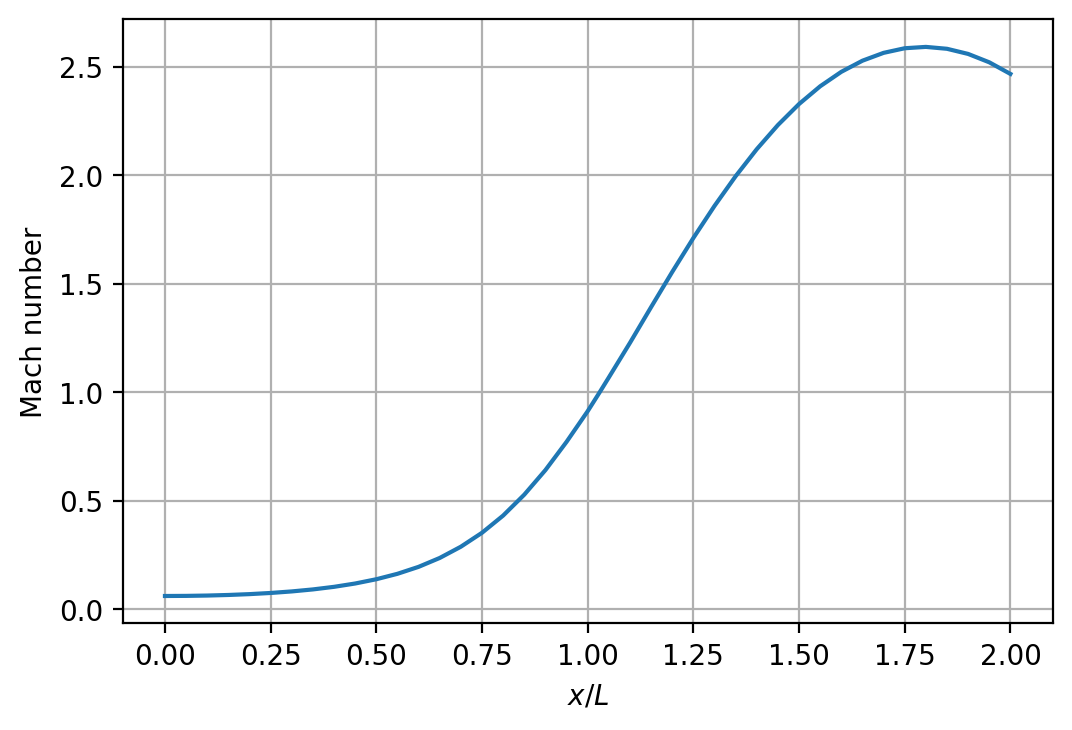

In [105]:
plt.plot(
    np.hstack((sol_sub.t[::-1], sol_super.t)), 
    np.hstack((sol_sub.y[0,::-1], sol_super.y[0,:]))
    )
plt.xlabel(r'$x / L$')
plt.ylabel('Mach number')
plt.grid(True)
plt.show()

In [108]:
# compare with isentropic
f = 0
x_L_sp = 1.0

# for solving quadratic equation at M = 1
Dsp = 2*(1 + 0.5*np.cos(np.pi*x_L_sp)) # * Dt
dD_dx_sp = -np.pi * np.sin(np.pi * x_L_sp) # *Dt/L
d2D_dx2_sp = -np.pi**2 * np.cos(np.pi * x_L_sp) # * Dt/L^2

a = 4 / (gamma + 1)
b = 2 * gamma * f / Dsp
c = -2*d2D_dx2_sp/Dsp + 2*(dD_dx_sp/Dsp)**2 - 2*gamma*f*dD_dx_sp/(2*Dsp**2)

# dM/d(x/L) at sonic point
roots = np.roots([a, b, c])
# take the positive root for accelerating flow
dM_dxL_sp = np.max(roots)


# integrate x/L from sonic point to 0
x_vals = np.hstack((np.arange(1, 0, -0.05), [0]))

sol_sub_isen = solve_ivp(
    dMdx_friction_area, [x_L_sp, 0], [1.0], 
    t_eval=x_vals,
    args=(gamma, area_function, f, diameter_function, dM_dxL_sp)
    )

# integrate x/L from sonic point to 2
x_vals = np.arange(1.0, 2.05, 0.05)

sol_super_isen = solve_ivp(
    dMdx_friction_area, [x_vals[0], x_vals[-1]], [1.0], 
    t_eval=x_vals,
    args=(gamma, area_function, f, diameter_function, dM_dxL_sp)
    )

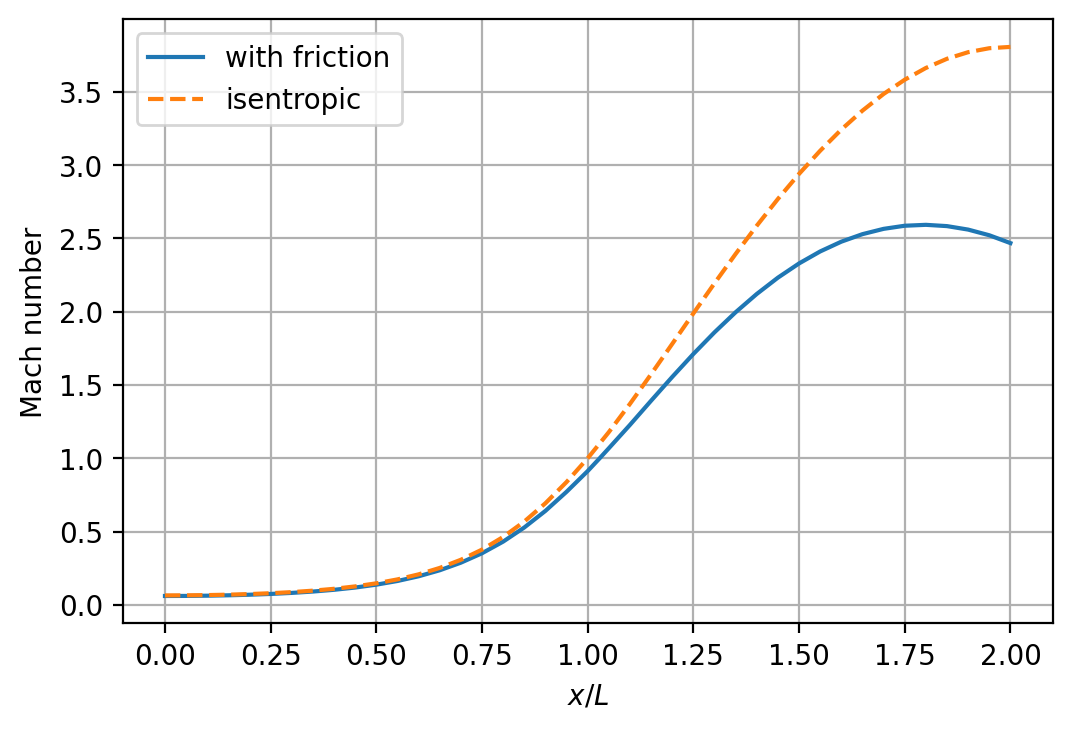

In [109]:
plt.plot(
    np.hstack((sol_sub.t[::-1], sol_super.t)), 
    np.hstack((sol_sub.y[0,::-1], sol_super.y[0,:])), label='with friction'
    )

plt.plot(
    np.hstack((sol_sub_isen.t[::-1], sol_super_isen.t)), 
    np.hstack((sol_sub_isen.y[0,::-1], sol_super_isen.y[0,:])), '--', label='isentropic'
    )

plt.xlabel(r'$x / L$')
plt.ylabel('Mach number')
plt.grid(True)
plt.legend()
plt.show()

We can see that the presence of friction starts to significantly alter the flow in the supersonic region, decelerating the flow from the isentropic solution and even causing the Mach number to begin decreasing near the exit. This is an extreme case, due to the high friction factor.

## Flows with heat transfer and area change

When the flow encounters both area change and heat transfer, we can use the ordinary differential equation

$$
\frac{dM}{dx} = \frac{M}{1 - M^2} \left[ \left(1 + \frac{\gamma-1}{2} M^2 \right) \frac{1}{A} \frac{dA}{dx} + \frac{1 + \gamma M^2}{2} \left( \frac{1}{c_p T} \frac{\delta q}{dx} \right) \right]
$$ (eq_heat_transfer_area)

To integrate $M(x)$, we need to know how the area changes with position and the rate that heat transfer occurs with distance.

As an example, consider air flow in a diverging conical nozzle of length 10 cm, where the diameter grows linearly with distance from 2 cm to 5 cm. 
The air enters the nozzle at a Mach number of 3 with a stagnation temperature of 300 K.
Heat is added at a rate such that $ \frac{dT_t}{dx} $ = 30 K/m.
Due to the pressure at the exit, there is a normal shock wave halfway down the nozzle.

Thanks to our relationship between heat transfer and stagnation temperature, $\delta q = c_p d T_t$, and our prior stagnation relationship for temperature, we can rewrite Equation {eq}`eq_heat_transfer_area` for this problem:

$$
\frac{dM}{dx} = \frac{M \left[ 2 + (\gamma-1) M^2 \right]}{2 (1-M^2)} \left[ -\frac{1}{A} \frac{dA}{dx} + \frac{1+\gamma M^2}{2} \left( \frac{1}{T_t} \frac{dT_t}{dt} \right) \right] \;.
$$

The nozzle diameter varies linearly with length:

$$
D(x) = D_i + (D_e - D_i) \frac{x}{L} \;,
$$

and so we can express the area and rate of change of area as

$$
\begin{gather*}
A(x) = \frac{\pi}{4} D(x)^2 = \frac{\pi}{4} \left[ D_i + (D_e - D_i) \frac{x}{L} \right]^2 \\
\rightarrow \frac{1}{A(x)} \frac{dA}{dx} = \frac{2}{D(x)} \frac{dD}{dx} = 2 \frac{\frac{D_e-D_i}{L}}{D(x)} = \frac{2 \alpha}{D(x} 
\end{gather*}
$$

where $ \alpha = (D_e - D_i) / L = 0.3 $ and $ D(x) = D_i + \alpha x $.
This leads to a specific $dM / dx$ for this problem:

$$
\frac{dM}{dx} = \frac{M \left[ 2 + (\gamma-1) M^2 \right]}{2(1-M^2)} \left[ - \left( \frac{2\alpha}{D_i + \alpha x} \right) + \left( \frac{1 + \gamma M^2}{2} \right) \left( \frac{\beta}{(T_t)_i + \beta x} \right) \right]
$$

and we can write a function that evaluates this:

In [7]:
def dMdx_heat_area(x, M, gamma, alpha, beta, D_in, Tt_in):
    '''Returns dM/dx for nozzle with heat transfer and area change'''
    return (
        0.5 * M * (2 + (gamma-1)*M**2) / (1 - M**2) * (
            -2*alpha/(D_in + alpha*x) + 
            0.5*(1+gamma*M**2) * beta / (Tt_in + beta*x)
            )
        )

We also need to handle the normal shock wave at the middle of the nozzle.
The shock is a discontinuity at $x = 0.5 L$, and so we can only integrate for $M(x)$ from $x = [0, 0.5 L]$ before we need to account for the shock by using our normal shock relationship. Then, using the new Mach number following the shock, we can continue the integration over $ x = [0.5 L, L] $.

For comparison, we can also calculate the adiabatic flow solution, which is isentropic except for the normal shock.

In [25]:
def normal_shock(mach, gamma=1.4):
    '''Returns Mach number after normal shock wave'''
    return np.sqrt(
        (mach**2 + 2/(gamma-1)) / (2*gamma*mach**2/(gamma-1) - 1)
        )

In [26]:
# problem parameters
mach_in = 3.0
gamma = 1.4

diam_in = Q_(2, 'cm').to('m')
diam_exit = Q_(5, 'cm').to('m')
length = Q_(10, 'cm').to('m')
alpha = ((diam_exit - diam_in) / length).to_base_units().magnitude

# shock location: x = 5 cm
stag_temp_in = 300
beta = 30 # K/m

In [27]:
# first solve to shock over x = [0, 0.5 L]:
sol_1 = solve_ivp(
    dMdx_heat_area, [0, length.magnitude / 2], [mach_in],
    max_step = 0.001,
    args=(gamma, alpha, beta, diam_in.magnitude, stag_temp_in)
    )

# find the Mach number after the normal shock
mach_post_shock = normal_shock(sol_1.y[0,-1], gamma)

# complete the integration over x = [0.5 L, L]:
sol_2 = solve_ivp(
    dMdx_heat_area, [length.magnitude / 2, length.magnitude], [mach_post_shock],
    max_step = 0.001,
    args=(gamma, alpha, beta, diam_in.magnitude, stag_temp_in)
    )

In [28]:
# adiabatic solution: isentropic except for the shock
# first solve to shock over x = [0, 0.5 L]:
sol_1_adiabatic = solve_ivp(
    dMdx_heat_area, [0, length.magnitude / 2], [mach_in],
    max_step = 0.001,
    args=(gamma, alpha, 0.0, diam_in.magnitude, stag_temp_in)
    )

# find the Mach number after the normal shock
mach_post_shock_adiabatic = normal_shock(sol_1_adiabatic.y[0,-1], gamma)

# complete the integration over x = [0.5 L, L]:
sol_2_adiabatic = solve_ivp(
    dMdx_heat_area, [length.magnitude / 2, length.magnitude], [mach_post_shock_adiabatic],
    max_step = 0.001,
    args=(gamma, alpha, 0.0, diam_in.magnitude, stag_temp_in)
    )

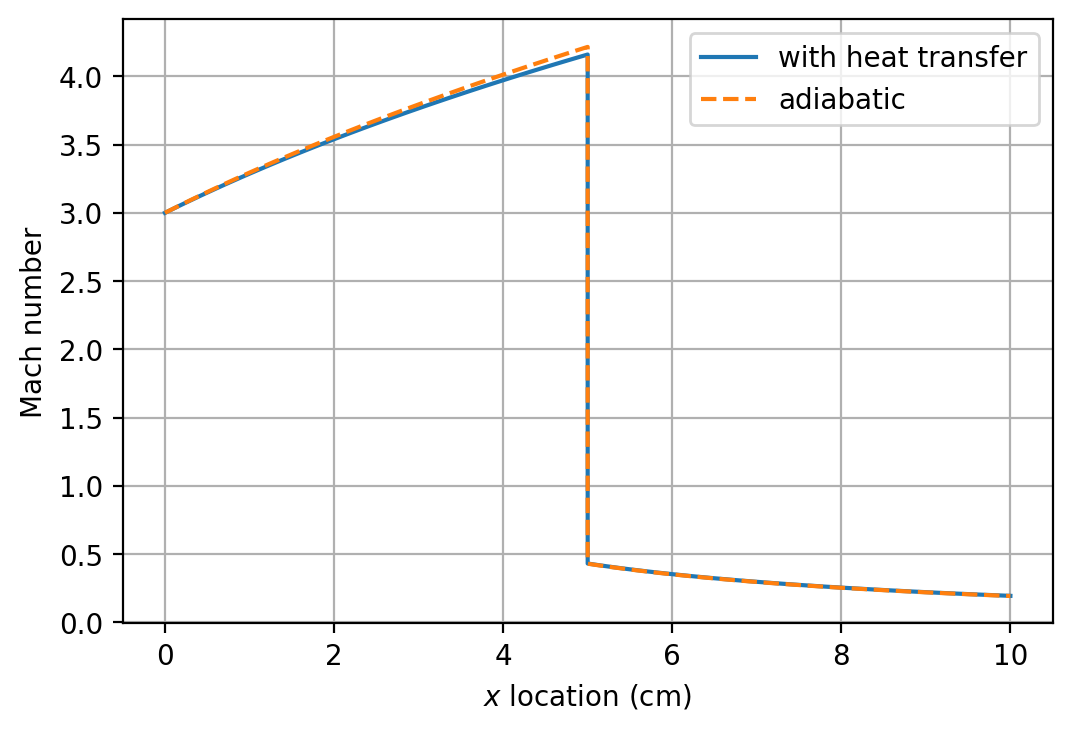

Exit Mach:  0.1941
Exit Mach (adiabatic):  0.1931


In [29]:
plt.plot(
    np.hstack((sol_1.t, sol_2.t)) * 100, 
    np.hstack((sol_1.y[0,:], sol_2.y[0,:])),
    label='with heat transfer'
    )
plt.plot(
    np.hstack((sol_1_adiabatic.t, sol_2_adiabatic.t)) * 100, 
    np.hstack((sol_1_adiabatic.y[0,:], sol_2_adiabatic.y[0,:])),
    '--', label='adiabatic'
    )
plt.grid(True)
plt.legend()
plt.xlabel(r'$x$ location (cm)')
plt.ylabel('Mach number')
plt.show()

print(f'Exit Mach: {sol_2.y[0,-1]: .4f}')
print(f'Exit Mach (adiabatic): {sol_2_adiabatic.y[0,-1]: .4f}')

We can see that in the supersonic region of the nozzle, the heat addition slightly decelerates the flow from isentropic, as we would expect in a supersonic Rayleigh flow, but the area change plays a much bigger role. Following the normal shock, the full solution tracks the adiabatic solution closely, but with a slightly higher exit Mach number.